In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import MITgcmutils as mitgcm
import xmitgcm 

%matplotlib inline

In [ ]:
# % Generate example of OB input files for tidal-component velocity field

# % Tidal-component OB input files are real*4 IEEE big-endian binary
# % with dimension: OBlength x nTidalComp,
# % where OBlength is the length of the open boundary and nTidalComp is the
# % number of tidal components to use (i.e., the last non-zero "OBCS_tidalPeriod"
# %  from "data.obcs"), not larger than "OBCS_tideCompSize" from "OBCS_PARAMS.h".

# % OB[N,S,E,W][am,ph][N,T]File :: Files with boundary conditions,
# %                                the letter combinations mean:
# %     N/S/E/W   :: northern/southern/eastern/western boundary
# %     am/ph     :: tidal amplitude (m/s) / phase (s)
# %     N/T       :: for the velocity Normal-component / Tangential-component

# % Tidal periods are specified using variable "OBCS_tidalPeriod" in "data.obcs"
# % Tidal amplitude is the maximum tidal velocity in m/s.
# % Tidal phase indicates time in s of maximum positive tide relative to model Time=0.

# %- note: uses writebin.m which can be found in: MITgcm/utils/matlab/cs_grid/read_cs

In [26]:
# Ho = 4000  # depth of ocean (m)
nx = 930    # gridpoints in x
ny = 1140    # gridpoints in y
xo = 112.5     # origin in x,y for ocean domain
yo = -3.3    # (i.e. southwestern corner of ocean domain)
dx = 1/60     # grid spacing in x (degrees longitude)
dy = 1/60     # grid spacing in y (degrees latitude)
xend  = xo + (nx-2)*dx   # eastern extent of ocean domain
yend = yo + (ny-2)*dy   # northern extent of ocean domain

x = np.linspace(xo-dx, xend, nx) + dx/2
y = np.linspace(yo-dy, yend, ny) + dy/2

nx = x.size
ny = y.size

X, Y = np.meshgrid(x, y)


In [3]:
# load the model topography 
ds_h = xr.open_dataset('h_bathymetry_model_grid.nc')
# get mask along each boundary
mask_south = np.where(ds_h.h.values[0,:]<0,1,0)
mask_north = np.where(ds_h.h.values[-1,:]<0,1,0)
mask_west = np.where(ds_h.h.values[:,0]<0,1,0)
mask_east = np.where(ds_h.h.values[:,-1]<0,1,0)

In [4]:
xsouth = X[0,:]
ysouth = Y[0,:]
xnorth = X[-1,:]
ynorth = Y[-1,:]

xwest = X[:,0]
ywest = Y[:,0]
xeast = X[:,-1]
yeast = Y[:,-1]

In [5]:
# load tide data (TPXO_10_atlas)
ds_tpxo_u = xr.open_dataset('/home/ceoas/liux8/work/basin_modes/TPXO/u_m2_tpxo10_atlas_30_v2.nc')
ds_tpxo_u

<xarray.Dataset> Size: 934MB
Dimensions:  (nx: 10800, ny: 5401)
Dimensions without coordinates: nx, ny
Data variables:
    con      |S4 4B ...
    lon_u    (nx) float64 86kB ...
    lat_u    (ny) float64 43kB ...
    lon_v    (nx) float64 86kB ...
    lat_v    (ny) float64 43kB ...
    uRe      (nx, ny) int32 233MB ...
    uIm      (nx, ny) int32 233MB ...
    vRe      (nx, ny) int32 233MB ...
    vIm      (nx, ny) int32 233MB ...
Attributes:
    type:     OTIS transport file
    title:    TPXO10_atlas_v2 tidal transport/current file

In [6]:
ds_tpxo_dep = xr.open_dataset('/home/ceoas/liux8/work/basin_modes/TPXO/grid_tpxo10atlas_v2.nc')
ds_tpxo_dep

<xarray.Dataset> Size: 700MB
Dimensions:  (nx: 10800, ny: 5401)
Dimensions without coordinates: nx, ny
Data variables:
    lon_z    (nx) float64 86kB ...
    lat_z    (ny) float64 43kB ...
    lon_u    (nx) float64 86kB ...
    lat_u    (ny) float64 43kB ...
    lon_v    (nx) float64 86kB ...
    lat_v    (ny) float64 43kB ...
    hz       (nx, ny) float32 233MB ...
    hu       (nx, ny) float32 233MB ...
    hv       (nx, ny) float32 233MB ...
Attributes:
    type:        OTIS Arakawa C-grid file
    title:       TPXO10_atlas_v2 bathymetry 1/30 resolution
    src_origin:  Mapped from NOAA GESTOFS bathymetry on z/u/v nodes
    src_url:     https://noaa-gestofs-pds.s3.amazonaws.com/index.html#_archiv...
    src_doc:     https://adcirc.org/home/documentation/users-manual-v53/input...

In [61]:
# fill the nans for lands and islands
# step 1: sub domain of the model region
ilonu = (ds_tpxo_u.lon_u.values> xo-1)&(ds_tpxo_u.lon_u.values<xend+1)
# ilatu = np.where((ds_tpxo_u.lat_u.values> yo-1)&(ds_tpxo_u.lat_u.values<yend+1))
# ds_tpxo_u.uRe.values[100:200,100:200]

ilonu[0]

False

In [50]:
# Prepare the interpolator for the toposulu data
interp_func_uRe = RegularGridInterpolator(
    (ds_tpxo_u.lon_u.values, ds_tpxo_u.lat_u.values),
    ds_tpxo_u.uRe.values/1e4/ds_tpxo_dep.hu.values,
    bounds_error=False,
    fill_value=np.nan
)
interp_func_uIm = RegularGridInterpolator(
    (ds_tpxo_u.lon_u.values, ds_tpxo_u.lat_u.values),
    ds_tpxo_u.uIm.values/1e4/ds_tpxo_dep.hu.values,
    bounds_error=False,
    fill_value=np.nan
)
interp_func_vRe = RegularGridInterpolator(
    (ds_tpxo_u.lon_v.values, ds_tpxo_u.lat_v.values),
    ds_tpxo_u.vRe.values/1e4/ds_tpxo_dep.hv.values,
    bounds_error=False,
    fill_value=np.nan
)
interp_func_vIm = RegularGridInterpolator(
    (ds_tpxo_u.lon_v.values, ds_tpxo_u.lat_v.values),
    ds_tpxo_u.vIm.values/1e4/ds_tpxo_dep.hv.values,
    bounds_error=False,
    fill_value=np.nan
)
def interp_uv(xp,yp):
    pts = np.column_stack([xp,yp])
    uRe_pts = interp_func_uRe(pts)
    uIm_pts = interp_func_uIm(pts)
    vRe_pts = interp_func_vRe(pts)
    vIm_pts = interp_func_vIm(pts)
    return uRe_pts, uIm_pts, vRe_pts, vIm_pts

uRe_south, uIm_south, vRe_south, vIm_south = interp_uv(xsouth, ysouth)
uRe_north, uIm_north, vRe_north, vIm_north = interp_uv(xnorth, ynorth)
uRe_west, uIm_west, vRe_west, vIm_west = interp_uv(xwest, ywest)
uRe_east, uIm_east, vRe_east, vIm_east = interp_uv(xeast, yeast)

/tmp/ipykernel_1005717/2262663428.py:4: RuntimeWarning: divide by zero encountered in divide
  ds_tpxo_u.uRe.values/1e4/ds_tpxo_dep.hu.values,
/tmp/ipykernel_1005717/2262663428.py:4: RuntimeWarning: invalid value encountered in divide
  ds_tpxo_u.uRe.values/1e4/ds_tpxo_dep.hu.values,
/tmp/ipykernel_1005717/2262663428.py:10: RuntimeWarning: divide by zero encountered in divide
  ds_tpxo_u.uIm.values/1e4/ds_tpxo_dep.hu.values,
/tmp/ipykernel_1005717/2262663428.py:10: RuntimeWarning: invalid value encountered in divide
  ds_tpxo_u.uIm.values/1e4/ds_tpxo_dep.hu.values,
/tmp/ipykernel_1005717/2262663428.py:16: RuntimeWarning: divide by zero encountered in divide
  ds_tpxo_u.vRe.values/1e4/ds_tpxo_dep.hv.values,
/tmp/ipykernel_1005717/2262663428.py:16: RuntimeWarning: invalid value encountered in divide
  ds_tpxo_u.vRe.values/1e4/ds_tpxo_dep.hv.values,
/tmp/ipykernel_1005717/2262663428.py:22: RuntimeWarning: divide by zero encountered in divide
  ds_tpxo_u.vIm.values/1e4/ds_tpxo_dep.hv.value

/tmp/ipykernel_1013520/1146082069.py:1: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(ds_tpxo_u.uRe.values[3400:3840,2601:3100]/ds_tpxo_dep.hu.values[3400:3840,2601:3100])


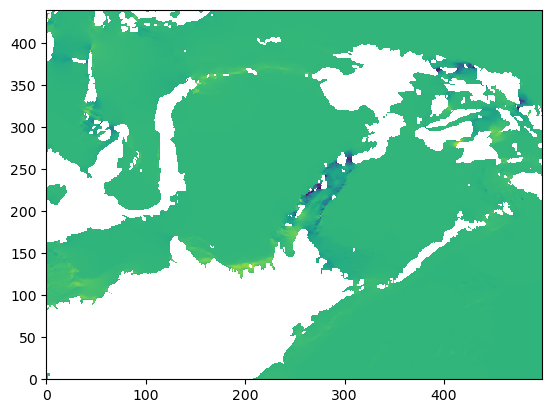

In [22]:
plt.pcolormesh(ds_tpxo_u.uRe.values[3400:3840,2601:3100]/ds_tpxo_dep.hu.values[3400:3840,2601:3100])

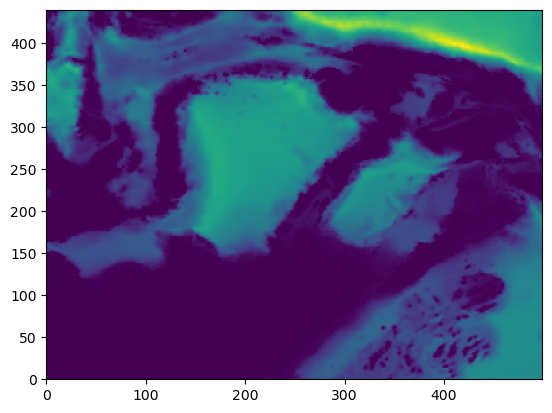

In [21]:
plt.pcolormesh(ds_tpxo_dep.hu.values[3400:3840,2601:3100])

(200.0, 400.0)

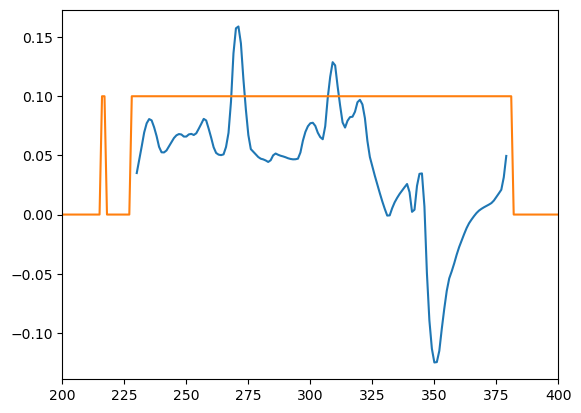

In [51]:
plt.plot(uRe_south)
plt.plot(mask_south*0.1)
plt.xlim(200,400)

In [33]:
period_m2 = 12.4206*3600

def get_amp_pha(uRe,uIm,period):
    u_amp = np.sqrt(uRe**2+uIm**2)
    u_pha = np.arctan2(-uIm,uRe)/(2*np.pi)*period
    return u_amp, u_pha

u_amp_south, u_pha_south = get_amp_pha(uRe_south, uIm_south,period_m2)
v_amp_south, v_pha_south = get_amp_pha(vRe_south, vIm_south,period_m2)

u_amp_north, u_pha_north = get_amp_pha(uRe_north, uIm_north,period_m2)
v_amp_north, v_pha_north = get_amp_pha(vRe_north, vIm_north,period_m2)

u_amp_west, u_pha_west = get_amp_pha(uRe_west, uIm_west,period_m2)
v_amp_west, v_pha_west = get_amp_pha(vRe_west, vIm_west,period_m2)

u_amp_east, u_pha_east = get_amp_pha(uRe_east, uIm_east,period_m2)
v_amp_east, v_pha_east = get_amp_pha(vRe_east, vIm_east,period_m2)

In [34]:
# create tidal input files

nTidalComp=1 # M2

for ob in ['N', 'S', 'E', 'W']:
    OBlength = ny
    if ob in ['N', 'S']:
        OBlength = nx

    for fld in ['am', 'ph']:
        fnm1 = f"tidalComp.OB{ob}{fld}Nvel.bin"
        fnm2 = f"tidalComp.OB{ob}{fld}Tvel.bin"

        var1 = np.zeros((OBlength, nTidalComp))
        var2 = np.zeros_like(var1)

        # --- North boundary ---
        # specify (0.03 m/s, 6 hr) for North boundary tidal component 3
        if ob == 'N':
            if fld == 'am':
                var1[:, 0] = v_amp_north              # component 3 → index 2
            else:
                var1[:, 0] = v_pha_north

            # Tangential velocity
            if fld == 'am':
                var2[:, 0] = u_amp_north
            else:
                var2[:, 0] = u_pha_north

        # --- South boundary ---
        # specify ( 0.1 m/s, 2 hr) for South boundary tidal component 1
        if ob == 'S':
            if fld == 'am':
                var1[:, 0] = v_amp_south               # component 1 → index 0
            else:
                var1[:, 0] = v_pha_south

            # Tangential velocity
            if fld == 'am':
                var2[:, 0] = u_amp_south
            else:
                var2[:, 0] = u_pha_south

        # --- East boundary ---
        # specify ( 0.1 m/s, 4 hr) for  East boundary tidal component 2
        if ob == 'E':
            if fld == 'am':
                var1[:, 0] = u_amp_east               # component 2 → index 1
            else:
                var1[:, 0] = u_pha_east

            # Tangential velocity
            if fld == 'am':
                var2[:, 0] = v_amp_east
            else:
                var2[:, 0] = v_pha_east

        # --- West boundary ---
        # specify (0.02 m/s, 8 hr) for  West boundary tidal component 4
        if ob == 'W':
            if fld == 'am':
                var1[:, 0] = u_amp_west              # component 4 → index 3
            else:
                var1[:, 0] = u_pha_west

            # Tangential velocity
            if fld == 'am':
                var2[:, 0] = v_amp_west
            else:
                var2[:, 0] = v_pha_west

        # --- Write outputs ---
        print(f" writing bin file: {fnm1} ...")
        # writebin(fnm1, var1)
        var1.astype('float32').tofile(fnm1)

        print(" done")

        # if ob in ['S', 'E']:
        print(f" writing bin file: {fnm2} ...")
        # writebin(fnm2, var2)
        var2.astype('float32').tofile(fnm2)
        print(" done")


 writing bin file: tidalComp.OBNamNvel.bin ...
 done
 writing bin file: tidalComp.OBNamTvel.bin ...
 done
 writing bin file: tidalComp.OBNphNvel.bin ...
 done
 writing bin file: tidalComp.OBNphTvel.bin ...
 done
 writing bin file: tidalComp.OBSamNvel.bin ...
 done
 writing bin file: tidalComp.OBSamTvel.bin ...
 done
 writing bin file: tidalComp.OBSphNvel.bin ...
 done
 writing bin file: tidalComp.OBSphTvel.bin ...
 done
 writing bin file: tidalComp.OBEamNvel.bin ...
 done
 writing bin file: tidalComp.OBEamTvel.bin ...
 done
 writing bin file: tidalComp.OBEphNvel.bin ...
 done
 writing bin file: tidalComp.OBEphTvel.bin ...
 done
 writing bin file: tidalComp.OBWamNvel.bin ...
 done
 writing bin file: tidalComp.OBWamTvel.bin ...
 done
 writing bin file: tidalComp.OBWphNvel.bin ...
 done
 writing bin file: tidalComp.OBWphTvel.bin ...
 done
